In [1]:
from numpy.random import seed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import itertools
import tensorflow
import tensorflow.keras
from tensorflow.keras.applications import ResNet152, Xception,VGG16,EfficientNetB4
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from scipy.ndimage.filters import sobel
from keras.layers import BatchNormalization
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
np.random.seed(123)

In [2]:
dataset = '../input/weather-dataset/dataset/'
labels = sorted(os.listdir(dataset))
image = []
label = []
for i in labels:
    st = dataset + i
    for j in os.listdir(st):
        stg = st +"/"+ j
        label.append(i)
        image.append(stg)
        
WeatherData = pd.DataFrame({'label':label, 'path' : image}, columns = ['label', 'path'])

In [3]:
new_labels = {
    'Rainy': ['rain', 'hail', 'lightning','rainbow'],
    'Dusty': ['sandstorm', 'fogsmog'],
    'Cold': ['dew', 'glaze', 'rime', 'snow', 'frost']
}

Target = []
for l in label:
    if l in new_labels['Rainy']:
        Target.append('Rainy')
    elif l in new_labels['Dusty']:
        Target.append('Dusty')
    elif l in new_labels['Cold']:
        Target.append('Cold')
        
WeatherData['Target'] = Target

In [4]:
WeatherData['image'] = WeatherData['path'].map(lambda x: np.asarray(Image.open(x).resize((100,100), Image.LANCZOS).convert('RGB')))

In [5]:
WeatherData = WeatherData.sample(frac=1, random_state=42)

In [6]:
def Accuracies(model, x_train, x_validate, x_test, y_train, y_validate ,y_test):
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
    loss_t, accuracy_t = model.evaluate(x_train, y_train, verbose=0)
    print("Training: accuracy = %f" % (accuracy_t))
    print("Validation: accuracy = %f" % (accuracy_v))
    print("Test: accuracy = %f" % (accuracy))

In [7]:
def ConfusionMatrix(model, x_test,y_test,label_encoder):
    predictions = np.array(list(map(lambda x: np.argmax(x), model.predict(x_test))))
    categories = label_encoder.classes_
    CM = confusion_matrix(np.argmax(y_test, axis=1), predictions)
    CMatrix = pd.DataFrame(CM, columns = categories, index = categories)
    plt.figure(figsize=(12, 6)) 
    ax = sns.heatmap(CMatrix, annot = True, fmt = 'g',vmax = min(np.diagonal(CM)),cmap = 'ocean_r') 
    ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold') 
    ax.set_xticklabels(ax.get_xticklabels(),rotation =90); 
    ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')
    ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);
    plt.show()

In [8]:
def ClassificationReport(model, x_test,y_test):
    y_pred = model.predict(x_test)
    y_test_cat = np.argmax(y_test, axis=1)
    y_pred_cat = np.argmax(y_pred, axis=1)

    print(classification_report(y_test_cat, y_pred_cat))

# Weather Condition Model: Cold, Dusty or Rainy

In [9]:
WeatherData['Target'].value_counts()

Cold     3593
Rainy    1726
Dusty    1543
Name: Target, dtype: int64

In [10]:
Features = np.stack(WeatherData['image'].values)
Target = WeatherData['Target']

In [11]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(Features, Target, test_size=0.3,random_state=666)
x_train = np.asarray(x_train_o.tolist())
x_test = np.asarray(x_test_o.tolist())
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)
x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [12]:
label_encoder = LabelEncoder()
y_train_o = label_encoder.fit_transform(y_train_o)
y_test_o = label_encoder.transform(y_test_o)
y_train = to_categorical(y_train_o, num_classes = 3)
y_test = to_categorical(y_test_o, num_classes = 3)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 999, stratify=y_train)

In [13]:
input_shape = (100, 100, 3)
num_classes = 3

In [14]:
x_train = x_train.reshape(x_train.shape[0], *(100, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 100, 3))

In [15]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in vgg_model.layers:
    layer.trainable = False

x = Flatten()(vgg_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=x)

58889256/58889256 [==============================] - 2s 0us/step


In [16]:
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=False)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=4, verbose=1, factor=0.5, min_lr=0.00001)

#Data Generation
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range = 10) 
datagen.fit(x_train)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
history = model.fit(datagen.flow(x_train,y_train, batch_size=64),
                              epochs = 100, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // 64
                              , callbacks=[learning_rate_reduction])

Epoch 1/100
60/60 [==============================] - 20s 209ms/step - loss: 0.7281 - accuracy: 0.7218 - val_loss: 0.3745 - val_accuracy: 0.8564 - lr: 0.0010
Epoch 2/100
60/60 [==============================] - 9s 160ms/step - loss: 0.3534 - accuracy: 0.8587 - val_loss: 0.2664 - val_accuracy: 0.9022 - lr: 0.0010
Epoch 3/100
60/60 [==============================] - 9s 156ms/step - loss: 0.3071 - accuracy: 0.8777 - val_loss: 0.2581 - val_accuracy: 0.9011 - lr: 0.0010
Epoch 4/100
60/60 [==============================] - 10s 166ms/step - loss: 0.2765 - accuracy: 0.8915 - val_loss: 0.2270 - val_accuracy: 0.9168 - lr: 0.0010
Epoch 5/100
60/60 [==============================] - 9s 154ms/step - loss: 0.2592 - accuracy: 0.9034 - val_loss: 0.2575 - val_accuracy: 0.9011 - lr: 0.0010
Epoch 6/100
60/60 [==============================] - 9s 157ms/step - loss: 0.2537 - accuracy: 0.8999 - val_loss: 0.2121 - val_accuracy: 0.9188 - lr: 0.0010
Epoch 7/100
60/60 [==============================] - 10s 166ms

In [17]:
Accuracies(model, x_train, x_validate, x_test, y_train, y_validate ,y_test)

Training: accuracy = 0.982041
Validation: accuracy = 0.939646
Test: accuracy = 0.932977


65/65 [==============================] - 1s 16ms/step


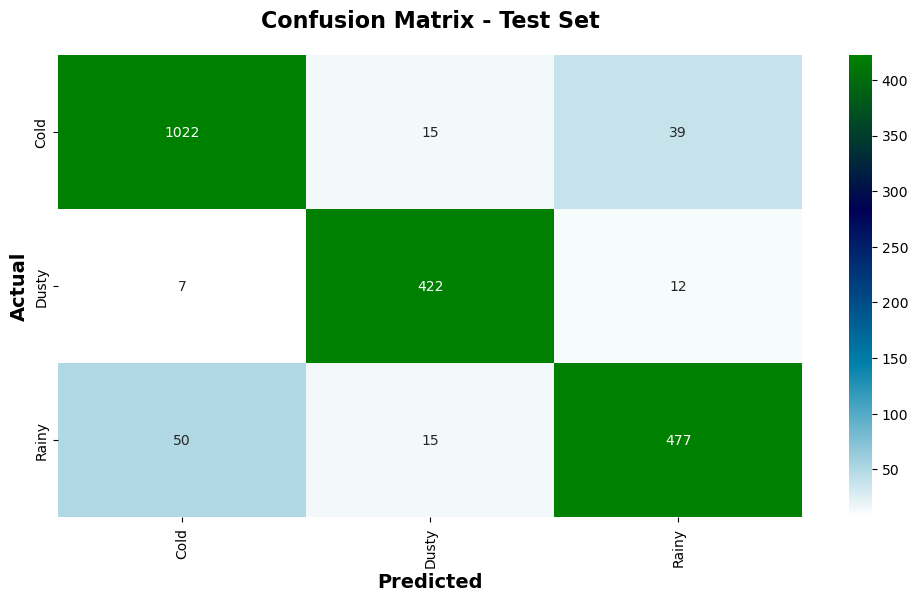

In [18]:
ConfusionMatrix(model, x_test, y_test, label_encoder)

In [19]:
ClassificationReport(model, x_test, y_test)

65/65 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1076
           1       0.93      0.96      0.95       441
           2       0.90      0.88      0.89       542

    accuracy                           0.93      2059
   macro avg       0.93      0.93      0.93      2059
weighted avg       0.93      0.93      0.93      2059



In [20]:
model.save('model_main.h5')

# Cold Weather

In [21]:
WeatherData_Cold = WeatherData[WeatherData.Target == 'Cold']

In [22]:
WeatherData_Cold.columns

Index(['label', 'path', 'Target', 'image'], dtype='object')

In [23]:
WeatherData_Cold['label'].value_counts()

rime     1160
dew       698
glaze     639
snow      621
frost     475
Name: label, dtype: int64

In [24]:
Cold_SHD = {
    'Safe': ['dew', 'frost'],
    'Potentially Hazardous': ['glaze', 'rime','snow']
}

New_Target = []
for l in WeatherData_Cold.label:
    if l in Cold_SHD['Safe']:
        New_Target.append('Safe')
    else:
        New_Target.append('Potentially Hazardous')
        
WeatherData_Cold['SPHD'] = New_Target

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [25]:
WeatherData_Cold['SPHD'].unique()

array(['Safe', 'Potentially Hazardous'], dtype=object)

In [26]:
Features = np.stack(WeatherData_Cold['image'].values)
Target = WeatherData_Cold['label']

In [27]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(Features, Target, test_size=0.3,random_state=666)
x_train = np.asarray(x_train_o.tolist())
x_test = np.asarray(x_test_o.tolist())
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)
x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [28]:
label_encoder = LabelEncoder()
y_train_o = label_encoder.fit_transform(y_train_o)
y_test_o = label_encoder.transform(y_test_o)
y_train = to_categorical(y_train_o, num_classes = 5)
y_test = to_categorical(y_test_o, num_classes = 5)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 999, stratify=y_train)

In [29]:
x_train = x_train.reshape(x_train.shape[0], *(100, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 100, 3))

In [30]:
num_classes = 5
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in vgg_model.layers:
    layer.trainable = False
x = Flatten()(vgg_model.output)
x = Dense(256, activation='relu')(x)


x = Dense(num_classes, activation='softmax')(x)
model_cold = Model(inputs=vgg_model.input, outputs=x)

In [31]:
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=False)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=4, verbose=1, factor=0.5, min_lr=0.00001)

datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range = 10) 
datagen.fit(x_train)

model_cold.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
history = model_cold.fit(datagen.flow(x_train,y_train, batch_size=64),
                              epochs = 100, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // 64
                              , callbacks=[learning_rate_reduction])

Epoch 1/100
31/31 [==============================] - 8s 206ms/step - loss: 0.9653 - accuracy: 0.6412 - val_loss: 0.7267 - val_accuracy: 0.7356 - lr: 0.0010
Epoch 2/100
31/31 [==============================] - 5s 172ms/step - loss: 0.6884 - accuracy: 0.7351 - val_loss: 0.6790 - val_accuracy: 0.7336 - lr: 0.0010
Epoch 3/100
31/31 [==============================] - 5s 164ms/step - loss: 0.6252 - accuracy: 0.7700 - val_loss: 0.6602 - val_accuracy: 0.7396 - lr: 0.0010
Epoch 4/100
31/31 [==============================] - 6s 201ms/step - loss: 0.5576 - accuracy: 0.7870 - val_loss: 0.6697 - val_accuracy: 0.7594 - lr: 0.0010
Epoch 5/100
31/31 [==============================] - 5s 161ms/step - loss: 0.5423 - accuracy: 0.7895 - val_loss: 0.6706 - val_accuracy: 0.7416 - lr: 0.0010
Epoch 6/100
31/31 [==============================] - 5s 163ms/step - loss: 0.5276 - accuracy: 0.8101 - val_loss: 0.6599 - val_accuracy: 0.7614 - lr: 0.0010
Epoch 7/100
31/31 [==============================] - 5s 165ms/st

In [32]:
Accuracies(model_cold, x_train, x_validate, x_test, y_train, y_validate ,y_test)

Training: accuracy = 0.944334
Validation: accuracy = 0.795229
Test: accuracy = 0.813544


34/34 [==============================] - 1s 17ms/step


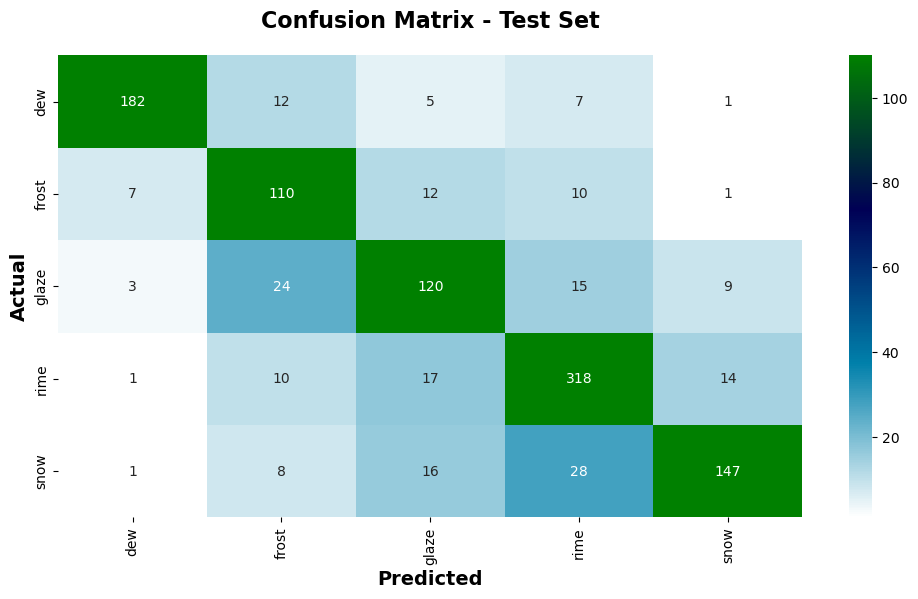

In [33]:
ConfusionMatrix(model_cold, x_test, y_test, label_encoder)

In [34]:
ClassificationReport(model_cold, x_test, y_test)

34/34 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       207
           1       0.67      0.79      0.72       140
           2       0.71      0.70      0.70       171
           3       0.84      0.88      0.86       360
           4       0.85      0.73      0.79       200

    accuracy                           0.81      1078
   macro avg       0.80      0.80      0.80      1078
weighted avg       0.82      0.81      0.81      1078



In [35]:
Target = WeatherData_Cold['SPHD']
num_classes = 2

In [36]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(Features, Target, test_size=0.3,random_state=666)
x_train = np.asarray(x_train_o.tolist())
x_test = np.asarray(x_test_o.tolist())
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)
x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [37]:
label_encoder = LabelEncoder()
y_train_o = label_encoder.fit_transform(y_train_o)
y_test_o = label_encoder.transform(y_test_o)
y_train = to_categorical(y_train_o, num_classes = 2)
y_test = to_categorical(y_test_o, num_classes = 2)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 999, stratify=y_train)

In [38]:
x_train = x_train.reshape(x_train.shape[0], *(100, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 100, 3))

In [39]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in vgg_model.layers:
    layer.trainable = False
x = Flatten()(vgg_model.output)
x = Dense(256, activation='relu')(x)


x = Dense(num_classes, activation='softmax')(x)
model_cold_wt = Model(inputs=vgg_model.input, outputs=x)

In [40]:
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=False)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=4, verbose=1, factor=0.5, min_lr=0.00001)

datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range = 10) 
datagen.fit(x_train)

model_cold_wt.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
history = model_cold_wt.fit(datagen.flow(x_train,y_train, batch_size=64),
                              epochs = 100, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // 64
                              , callbacks=[learning_rate_reduction])

Epoch 1/100
31/31 [==============================] - 7s 181ms/step - loss: 0.4687 - accuracy: 0.8296 - val_loss: 0.3016 - val_accuracy: 0.8787 - lr: 0.0010
Epoch 2/100
31/31 [==============================] - 5s 172ms/step - loss: 0.2734 - accuracy: 0.8860 - val_loss: 0.3096 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 3/100
31/31 [==============================] - 5s 161ms/step - loss: 0.2646 - accuracy: 0.8881 - val_loss: 0.2988 - val_accuracy: 0.8847 - lr: 0.0010
Epoch 4/100
31/31 [==============================] - 6s 184ms/step - loss: 0.2638 - accuracy: 0.8886 - val_loss: 0.2877 - val_accuracy: 0.8847 - lr: 0.0010
Epoch 5/100
31/31 [==============================] - 6s 176ms/step - loss: 0.2490 - accuracy: 0.8953 - val_loss: 0.3529 - val_accuracy: 0.8588 - lr: 0.0010
Epoch 6/100
31/31 [==============================] - 5s 158ms/step - loss: 0.2272 - accuracy: 0.9055 - val_loss: 0.3294 - val_accuracy: 0.8787 - lr: 0.0010
Epoch 7/100
31/31 [==============================] - 5s 163ms/st

In [41]:
Accuracies(model_cold_wt, x_train, x_validate, x_test, y_train, y_validate ,y_test)

Training: accuracy = 0.987575
Validation: accuracy = 0.918489
Test: accuracy = 0.926716


34/34 [==============================] - 1s 17ms/step


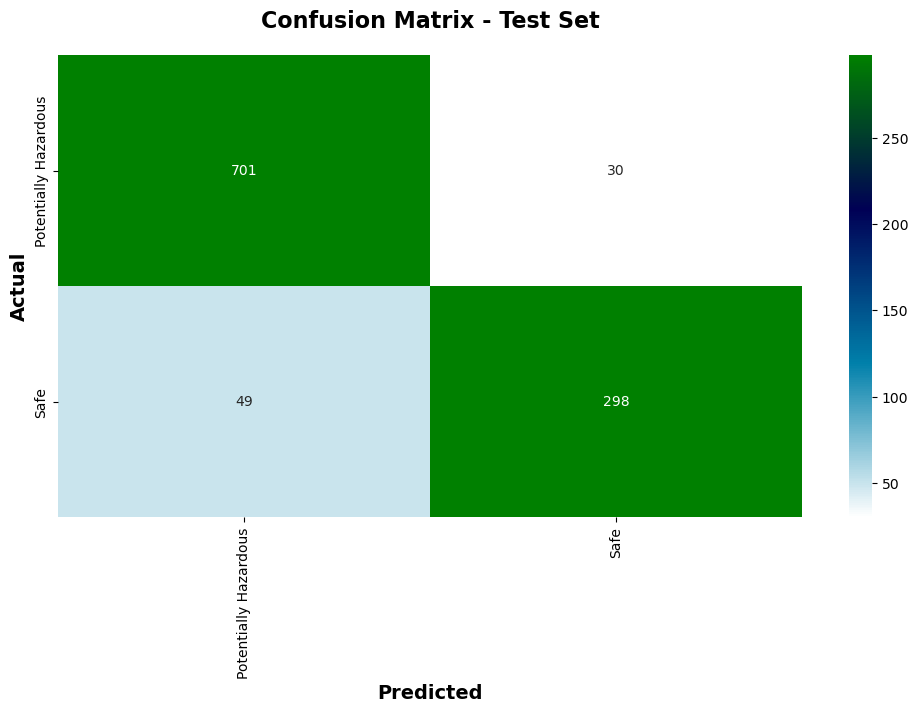

In [42]:
ConfusionMatrix(model_cold_wt, x_test, y_test, label_encoder)

In [43]:
ClassificationReport(model_cold_wt, x_test, y_test)

34/34 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       731
           1       0.91      0.86      0.88       347

    accuracy                           0.93      1078
   macro avg       0.92      0.91      0.91      1078
weighted avg       0.93      0.93      0.93      1078



In [44]:
model_cold.save('model_cold.h5')
model_cold_wt.save('model_cold_wt.h5')

# Dusty Weather

In [45]:
WeatherData_Dusty = WeatherData[WeatherData.Target == 'Dusty']

In [46]:
Features = np.stack(WeatherData_Dusty['image'].values)
Target = WeatherData_Dusty['label']
num_classes = 2

In [47]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(Features, Target, test_size=0.3,random_state=666)
x_train = np.asarray(x_train_o.tolist())
x_test = np.asarray(x_test_o.tolist())
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)
x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [48]:
label_encoder = LabelEncoder()
y_train_o = label_encoder.fit_transform(y_train_o)
y_test_o = label_encoder.transform(y_test_o)
y_train = to_categorical(y_train_o, num_classes = 2)
y_test = to_categorical(y_test_o, num_classes = 2)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 999, stratify=y_train)

In [49]:
x_train = x_train.reshape(x_train.shape[0], *(100, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 100, 3))

In [50]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in vgg_model.layers:
    layer.trainable = False
x = Flatten()(vgg_model.output)
x = Dense(256, activation='relu')(x)


x = Dense(num_classes, activation='softmax')(x)
model_dusty = Model(inputs=vgg_model.input, outputs=x)

In [51]:
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=False)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=4, verbose=1, factor=0.5, min_lr=0.00001)

datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range = 10) 
datagen.fit(x_train)

model_dusty.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
history = model_dusty.fit(datagen.flow(x_train,y_train, batch_size=64),
                              epochs = 100, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // 64
                              , callbacks=[learning_rate_reduction])

Epoch 1/100
13/13 [==============================] - 4s 226ms/step - loss: 0.9532 - accuracy: 0.6500 - val_loss: 0.5694 - val_accuracy: 0.6620 - lr: 0.0010
Epoch 2/100
13/13 [==============================] - 2s 154ms/step - loss: 0.4007 - accuracy: 0.8100 - val_loss: 0.3197 - val_accuracy: 0.8704 - lr: 0.0010
Epoch 3/100
13/13 [==============================] - 2s 155ms/step - loss: 0.2846 - accuracy: 0.8913 - val_loss: 0.2850 - val_accuracy: 0.8519 - lr: 0.0010
Epoch 4/100
13/13 [==============================] - 2s 192ms/step - loss: 0.2456 - accuracy: 0.9013 - val_loss: 0.2797 - val_accuracy: 0.8843 - lr: 0.0010
Epoch 5/100
13/13 [==============================] - 2s 156ms/step - loss: 0.2208 - accuracy: 0.9200 - val_loss: 0.2577 - val_accuracy: 0.8935 - lr: 0.0010
Epoch 6/100
13/13 [==============================] - 2s 164ms/step - loss: 0.2233 - accuracy: 0.9225 - val_loss: 0.2701 - val_accuracy: 0.8704 - lr: 0.0010
Epoch 7/100
13/13 [==============================] - 2s 156ms/st

In [52]:
Accuracies(model_dusty, x_train, x_validate, x_test, y_train, y_validate ,y_test)

Training: accuracy = 0.971065
Validation: accuracy = 0.907407
Test: accuracy = 0.909287


15/15 [==============================] - 0s 17ms/step


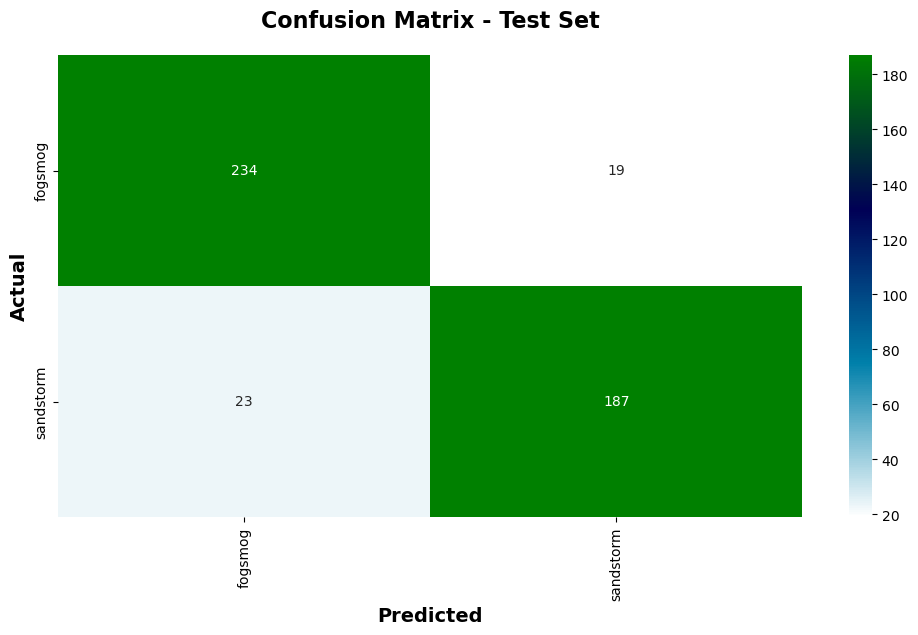

In [53]:
ConfusionMatrix(model_dusty, x_test, y_test, label_encoder)

In [54]:
ClassificationReport(model_dusty, x_test, y_test)

15/15 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       253
           1       0.91      0.89      0.90       210

    accuracy                           0.91       463
   macro avg       0.91      0.91      0.91       463
weighted avg       0.91      0.91      0.91       463



In [55]:
model_dusty.save('model_dusty.h5')

# Rainy Weather

In [56]:
WeatherData_Rainy = WeatherData[WeatherData.Target == 'Rainy']

In [57]:
Features = np.stack(WeatherData_Rainy['image'].values)
Target = WeatherData_Rainy['label']
num_classes = 4

In [58]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(Features, Target, test_size=0.3,random_state=666)
x_train = np.asarray(x_train_o.tolist())
x_test = np.asarray(x_test_o.tolist())
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)
x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [59]:
label_encoder = LabelEncoder()
y_train_o = label_encoder.fit_transform(y_train_o)
y_test_o = label_encoder.transform(y_test_o)
y_train = to_categorical(y_train_o, num_classes = 4)
y_test = to_categorical(y_test_o, num_classes = 4)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 999, stratify=y_train)

In [60]:
x_train = x_train.reshape(x_train.shape[0], *(100, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 100, 3))

In [61]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in vgg_model.layers:
    layer.trainable = False
x = Flatten()(vgg_model.output)
x = Dense(256, activation='relu')(x)


x = Dense(num_classes, activation='softmax')(x)
model_rainy = Model(inputs=vgg_model.input, outputs=x)

In [62]:
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=False)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=4, verbose=1, factor=0.5, min_lr=0.00001)

datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range = 10) 
datagen.fit(x_train)

model_rainy.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
history = model_rainy.fit(datagen.flow(x_train,y_train, batch_size=64),
                              epochs = 100, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // 64
                              , callbacks=[learning_rate_reduction])

Epoch 1/100
15/15 [==============================] - 4s 205ms/step - loss: 0.7164 - accuracy: 0.7428 - val_loss: 0.1457 - val_accuracy: 0.9711 - lr: 0.0010
Epoch 2/100
15/15 [==============================] - 2s 160ms/step - loss: 0.2340 - accuracy: 0.9146 - val_loss: 0.1489 - val_accuracy: 0.9463 - lr: 0.0010
Epoch 3/100
15/15 [==============================] - 3s 184ms/step - loss: 0.1824 - accuracy: 0.9335 - val_loss: 0.1770 - val_accuracy: 0.9339 - lr: 0.0010
Epoch 4/100
15/15 [==============================] - 3s 174ms/step - loss: 0.1466 - accuracy: 0.9424 - val_loss: 0.1016 - val_accuracy: 0.9752 - lr: 0.0010
Epoch 5/100
15/15 [==============================] - 2s 161ms/step - loss: 0.1152 - accuracy: 0.9623 - val_loss: 0.0922 - val_accuracy: 0.9752 - lr: 0.0010
Epoch 6/100
15/15 [==============================] - 2s 153ms/step - loss: 0.1076 - accuracy: 0.9601 - val_loss: 0.0789 - val_accuracy: 0.9793 - lr: 0.0010
Epoch 7/100
15/15 [==============================] - 2s 166ms/st

In [63]:
Accuracies(model_rainy, x_train, x_validate, x_test, y_train, y_validate ,y_test)

Training: accuracy = 0.996894
Validation: accuracy = 0.975207
Test: accuracy = 0.959459


17/17 [==============================] - 0s 16ms/step


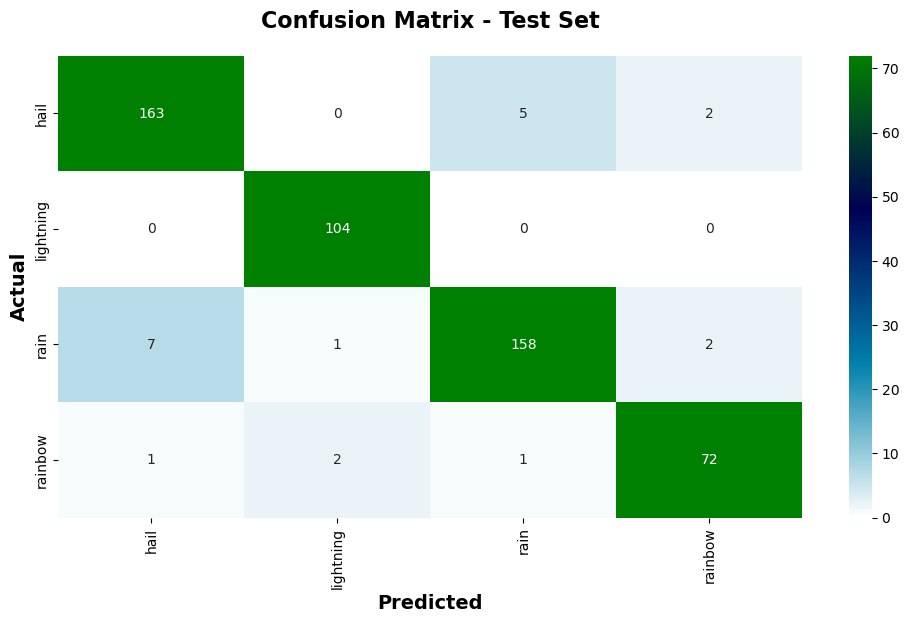

In [64]:
ConfusionMatrix(model_rainy, x_test, y_test, label_encoder)

In [65]:
ClassificationReport(model_rainy, x_test, y_test)

17/17 [==============================] - 0s 16ms/step
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       170
           1       0.97      1.00      0.99       104
           2       0.96      0.94      0.95       168
           3       0.95      0.95      0.95        76

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



In [66]:
model_rainy.save('model_rainy.h5')

# Prediction

1/1 [==============================] - 0s 21ms/step
[[5.540338e-06 5.870307e-03 9.941241e-01]]
99.41241145133972


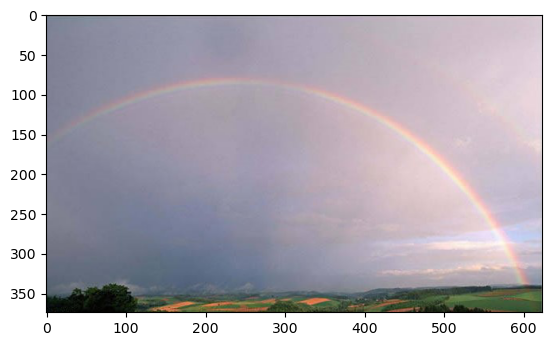

In [67]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image
from PIL import Image, ImageFilter

img = Image.open('/kaggle/input/weather-dataset/dataset/rainbow/0610.jpg')
plt.imshow(img)
img = img.resize((100, 100), resample=Image.LANCZOS).convert('RGB')
img_arr = np.asarray(img).reshape(1, 100, 100, 3)
img_arr = (img_arr - x_train_mean) / x_train_std

result = model.predict(img_arr)

print(result)
max_prob = np.argmax(result[0])
#print(categories[max_prob])
print(max(result[0])*100)